In [434]:
import pandas as pd, numpy as np, random
from datetime import date
from datetime import datetime

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline

## Import Data

In [884]:
input_df = pd.read_csv('/Users/psantanu/Downloads/loan_data.csv', sep = ',')
print('Shape of the dataframe >>> ', input_df.shape)
input_df.head()

Shape of the dataframe >>>  (10000, 29)


,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,...,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,...,13263.18,7273.77,4736.82,2536.95,NaN,NaN,10.16%,NaN,NaN,10.16
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,...,15294.25,496.78,380.75,116.03,NaN,NaN,8.90%,NaN,NaN,8.90
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,42000.0,Late (31-120 days),...,12966.64,5000.85,3533.36,1467.49,NaN,NaN,7.90%,NaN,NaN,7.90
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,55000.0,Fully Paid,...,0.00,5792.14,5500.00,292.14,NaN,NaN,13.67%,NaN,NaN,13.67
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,...,4430.59,2912.26,1969.41,942.85,NaN,NaN,15.80%,NaN,NaN,15.80


## Missing Values

In [885]:
input_df.isnull().sum()

id                            0
loan_amnt                     0
funded_amnt                   0
term                        476
int_rate                    476
installment                 476
emp_length                  881
home_ownership              476
annual_inc                  476
loan_status                 476
purpose                     476
addr_state                    0
dti                         476
delinq_2yrs                 476
earliest_cr_line            476
mths_since_last_delinq     5900
open_acc                    476
revol_bal                   476
total_acc                   476
out_prncp                   476
total_pymnt                 476
total_rec_prncp             476
total_rec_int               476
wtd_loans                 10000
interest_rate             10000
int_rate2                   476
num_rate                  10000
numrate                   10000
int_rate3                   476
dtype: int64

We see loan status field to have 476 mssing values. This sould help us create our target variable and help us understand the protfolio. We cannot impute the missing values. Hence, we remove records which are missing in loan status field

In [886]:
input_df = input_df[~input_df['loan_status'].isnull()]
input_df.shape

(9524, 29)

In [887]:
input_df['loan_status'].value_counts()

Current               8122
Fully Paid             951
Charged Off            218
Late (31-120 days)     148
In Grace Period         48
Late (16-30 days)       21
Default                 16
Name: loan_status, dtype: int64

Out of 9,524 loans, 8,122 (85%) are  current, 1,185 (12.4%) have status as fully paid or default or charged off, and rest 217 (2%) have late or grace period status


We have loans which are currently active. We don't know what would be the status of these loans in future. They might be good or bad, but there's no way of knowing since we are given a snapshot of data. 

However, we have some loans which are fully paid, and some loans which are already default and charged off. We can analyze these loans to understand what are the attributes that are driving loans to be "good" or "bad". We can then extrapolate these insights on loans with "Current" status to predict if these current loans are going to be good or bad in future. 

There are another kind of loans which are in Grace Period, or late. These loans haven't gone bad yet. But they are already Past Due, and are likely to be default or charged off if proper recovery is not conducted.



## Steps of Analysis

1. Conduct a exploratory analysis on the data to understand on high-level the current portfolio, and how each attribute affects loan status
2. Develop a model on loans which are either fully paid or defaulted or charged off.
3. Understand the attributes which influence the outcome of the model.
4. Use the model on loans which are "Current" and "Late" to understand the risk portfolio of active loans

## Defining "Good" and "Bad" loan

We will say a loan is "good" if it's fully paid. Whereas, if it's "default" or "charged-off" then it's "bad"

# 1. Exploratory Analysis

In [888]:
# Create loan status groups
def bucket_loan_status(row):
    if row in ['Default', 'Charged Off']:
        return 'bad_status'
    if row in ['Fully Paid']:
        return 'fully_paid_status' 
    elif row in ['Current']:
        return 'current_status'
    else:
        return 'late_status'

input_df['status_group'] = input_df['loan_status'].apply(lambda row: bucket_loan_status(row))

## Histogram of Loan Amount by Loan Status Group


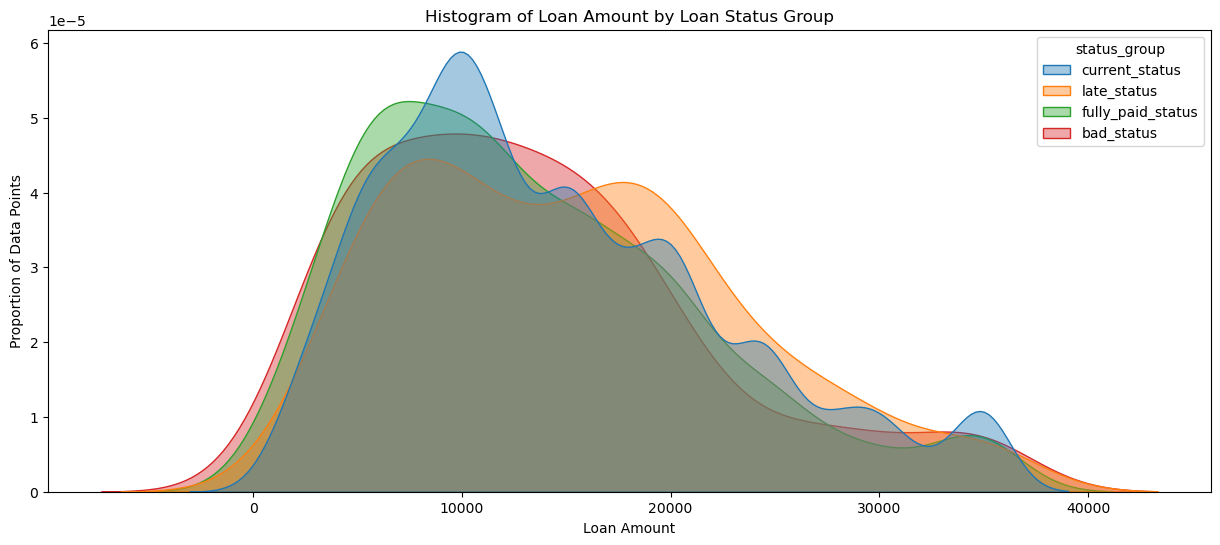

In [889]:
plt.figure(figsize=(15, 6))
sns.kdeplot(data=input_df, x="loan_amnt", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Loan Amount')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Loan Amount by Loan Status Group')
plt.show()


In [890]:
input_df.groupby(['status_group'], as_index = False).agg({'loan_amnt': ['mean', 'median']})

status_group     loan_amnt         
                              mean   median
0         bad_status  13434.722222  12087.5
1     current_status  14436.481162  12300.0
2  fully_paid_status  13341.692955  12000.0
3        late_status  15284.331797  15000.0

There's fair overlap between the 3 groups i.e loan amount has similar distributions across different status groups. Late Status loans seem to have higher loan amount.

## Histogram of Term by Loan Status Group

,status_group,field,loan_count,tot_loan,loan_pct
0,bad_status,36 months,179,234,0.764957
1,bad_status,60 months,55,234,0.235043
2,current_status,36 months,6184,8122,0.761389
3,current_status,60 months,1938,8122,0.238611
4,fully_paid_status,36 months,769,951,0.808623
5,fully_paid_status,60 months,182,951,0.191377
6,late_status,36 months,137,217,0.631336
7,late_status,60 months,80,217,0.368664


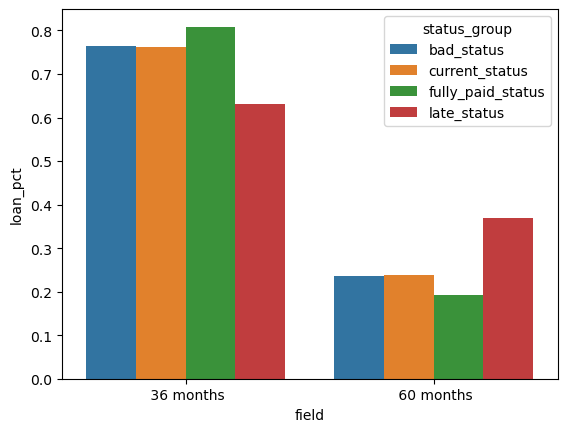

In [891]:
agg_df = pd.merge(left = input_df.groupby(['status_group', 'term'], as_index = False).agg({'id': 'count'}),
         right = input_df.groupby(['status_group'], as_index = False).agg({'id': 'count'}),
         on = 'status_group', how = 'inner')

agg_df.columns = ['status_group', 'field', 'loan_count', 'tot_loan']
agg_df['loan_pct'] = agg_df['loan_count']/agg_df['tot_loan']
agg_df

sns.barplot(data=agg_df, x='field', y='loan_pct', hue='status_group')

agg_df

Loans which have late status tend to have higher proportion of 60-month term

## Histogram of Interest Rate by Loan Status Group

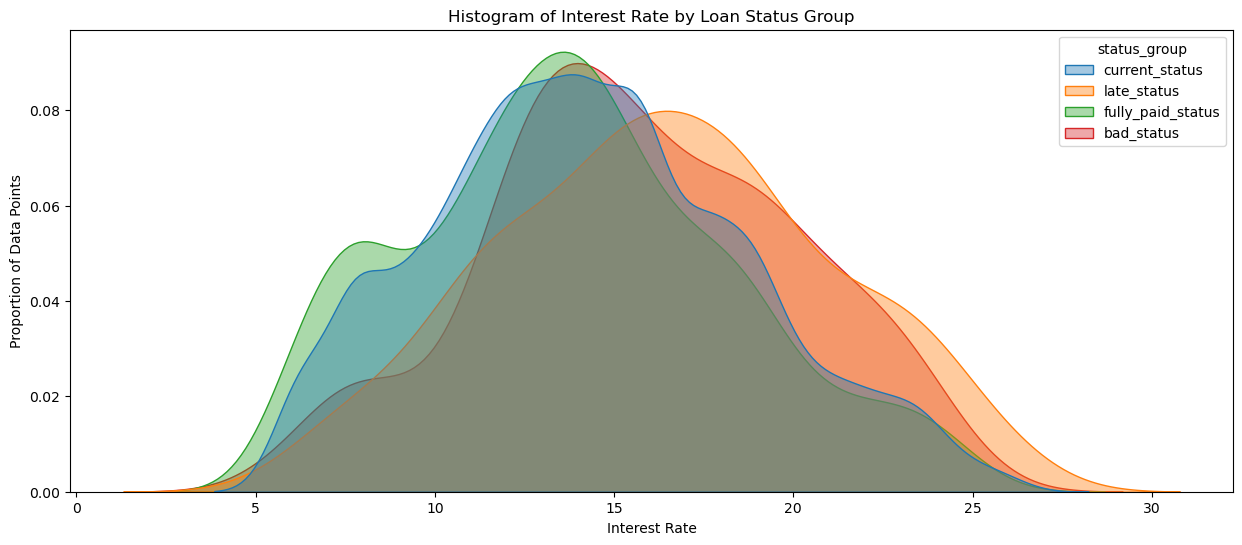

In [892]:
plt.figure(figsize=(15, 6))
sns.kdeplot(data=input_df, x="int_rate", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Interest Rate')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Interest Rate by Loan Status Group')
plt.show()


In [893]:
input_df.groupby(['status_group'], as_index = False).agg({'int_rate': ['mean', 'median']})

status_group   int_rate       
                           mean median
0         bad_status  15.767393  15.31
1     current_status  14.235694  14.09
2  fully_paid_status  13.791073  13.67
3        late_status  16.382811  16.29

Loans which are "late" or have gone "bad" (defaulted or charged off) tend to have higher interest rate

## Histogram of Monthly Installment by Loan Status Group

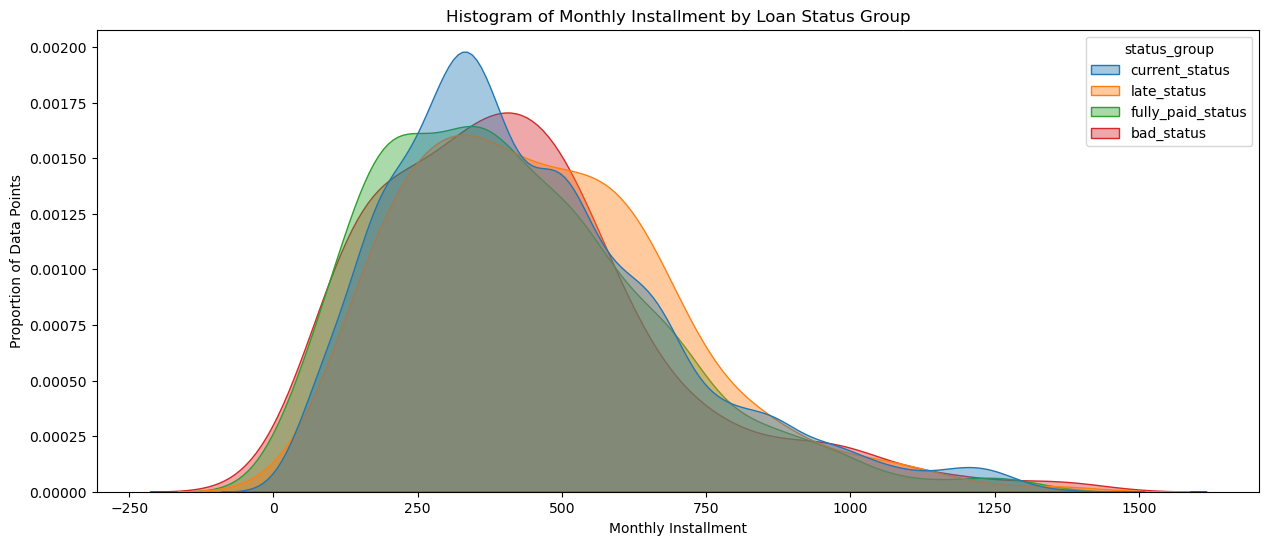

In [894]:
plt.figure(figsize=(15, 6))
sns.kdeplot(data=input_df, x="installment", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Monthly Installment')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Monthly Installment by Loan Status Group')
plt.show()


In [895]:
input_df.groupby(['status_group'], as_index = False).agg({'installment': ['mean', 'median']})

status_group installment         
                            mean   median
0         bad_status  422.583162  393.735
1     current_status  445.573699  398.640
2  fully_paid_status  417.700379  377.260
3        late_status  463.173687  437.150

For late status loans, we observe the monthly installments to be higher

## Histogram of Home Ownership by Loan Status Group

,status_group,field,loan_count,tot_loan,loan_pct
0,bad_status,MORTGAGE,91,234,0.388889
1,bad_status,OWN,20,234,0.085470
2,bad_status,RENT,123,234,0.525641
3,current_status,MORTGAGE,4171,8122,0.513543
6,current_status,OWN,696,8122,0.085693
7,current_status,RENT,3253,8122,0.400517
8,fully_paid_status,MORTGAGE,478,951,0.502629
9,fully_paid_status,OWN,88,951,0.092534
10,fully_paid_status,RENT,385,951,0.404837
11,late_status,MORTGAGE,99,217,0.456221


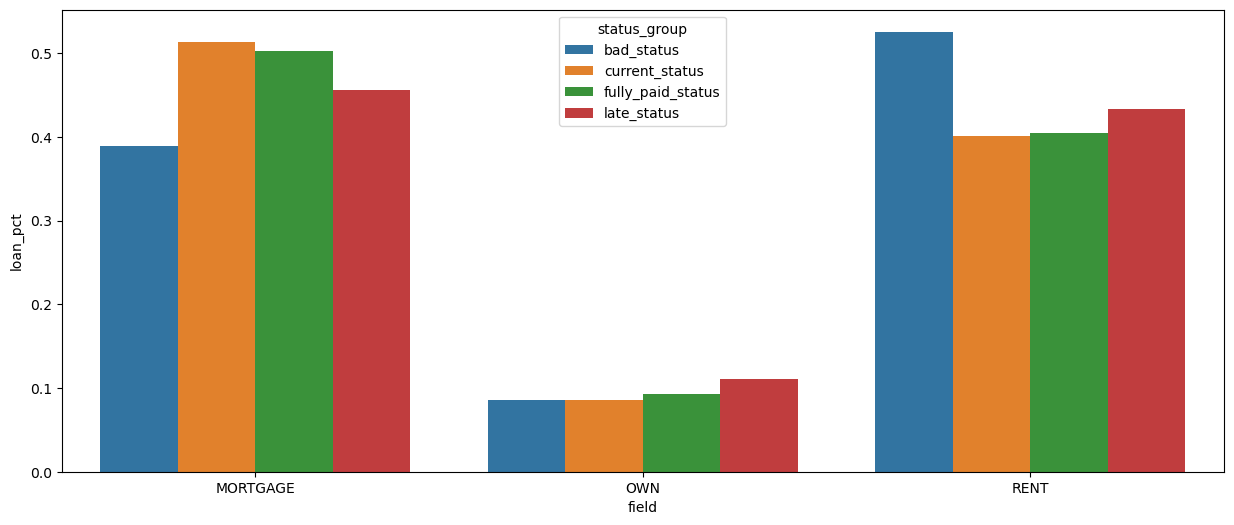

In [896]:
agg_df = pd.merge(left = input_df.groupby(['status_group', 'home_ownership'], as_index = False).agg({'id': 'count'}),
         right = input_df.groupby(['status_group'], as_index = False).agg({'id': 'count'}),
         on = 'status_group', how = 'inner')

agg_df.columns = ['status_group', 'field', 'loan_count', 'tot_loan']
agg_df['loan_pct'] = agg_df['loan_count']/agg_df['tot_loan']
agg_df = agg_df[~agg_df['field'].isin(['NONE', 'OTHER'])]

plt.figure(figsize=(15, 6))
sns.barplot(data=agg_df, x='field', y='loan_pct', hue='status_group')

agg_df

loans with Rental home ownership tend to go bad than with mortgage and own

## Histogram of Annual Income by Loan Status Group

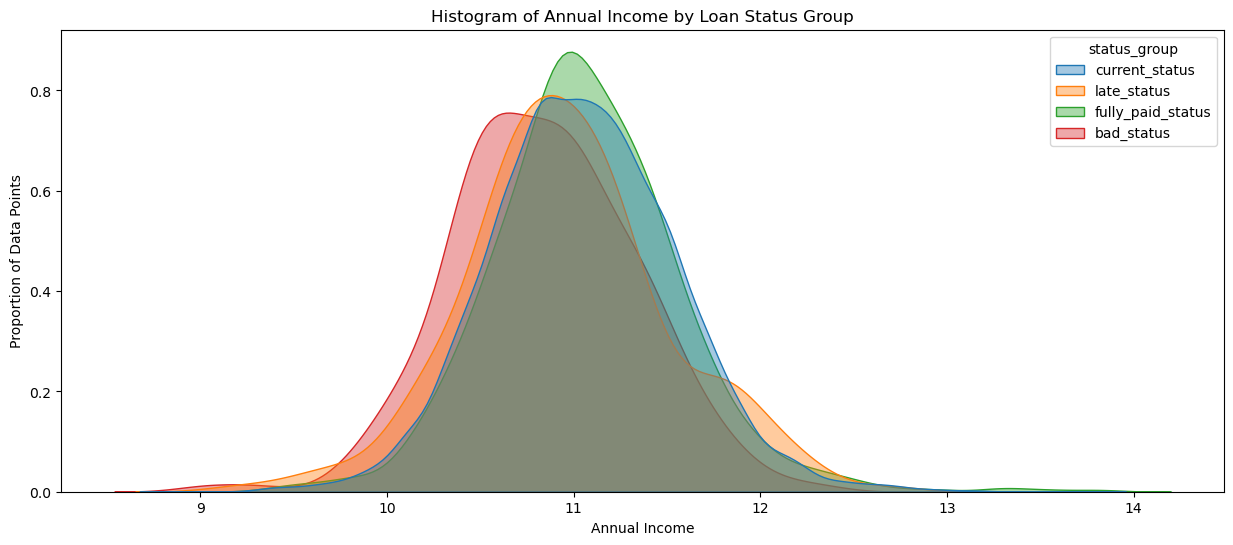

In [897]:
agg_df = input_df.copy()
agg_df['annual_inc_log'] = np.log(agg_df['annual_inc'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=agg_df, x="annual_inc_log", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Annual Income')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Annual Income by Loan Status Group')
plt.show()


Loans with owners having lower annual income tend to go bad, whereas higher income tend to be more fully paid

## Histogram of Purpose of Loan by Loan Status Group

,status_group,field,loan_count,tot_loan,loan_pct
0,bad_status,credit_card,34,234,0.145299
1,bad_status,debt_consolidation,152,234,0.649573
2,bad_status,home_improvement,4,234,0.017094
4,bad_status,major_purchase,3,234,0.012821
7,bad_status,other,17,234,0.072650
9,bad_status,small_business,10,234,0.042735
13,current_status,credit_card,1957,8122,0.240951
14,current_status,debt_consolidation,4829,8122,0.594558
15,current_status,home_improvement,415,8122,0.051096
17,current_status,major_purchase,153,8122,0.018838


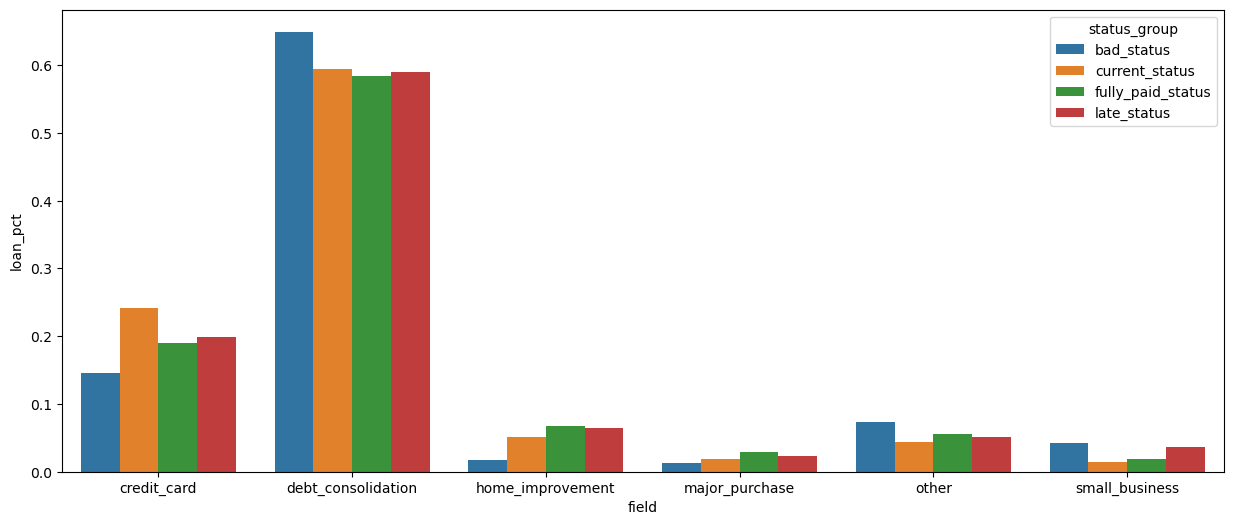

In [898]:
agg_df = pd.merge(left = input_df.groupby(['status_group', 'purpose'], as_index = False).agg({'id': 'count'}),
         right = input_df.groupby(['status_group'], as_index = False).agg({'id': 'count'}),
         on = 'status_group', how = 'inner')

agg_df.columns = ['status_group', 'field', 'loan_count', 'tot_loan']
agg_df['loan_pct'] = agg_df['loan_count']/agg_df['tot_loan']
agg_df = agg_df[agg_df['field'].isin(['credit_card', 'debt_consolidation', 'home_improvement', 'major_purchase',
                                     'other', 'small_business'])]

plt.figure(figsize=(15, 6))
sns.barplot(data=agg_df, x='field', y='loan_pct', hue='status_group')

agg_df

Loans taken for debt consolidation seems to have higher risk of going bad

## Histogram of Debt to Income Ratio by Loan Status Group

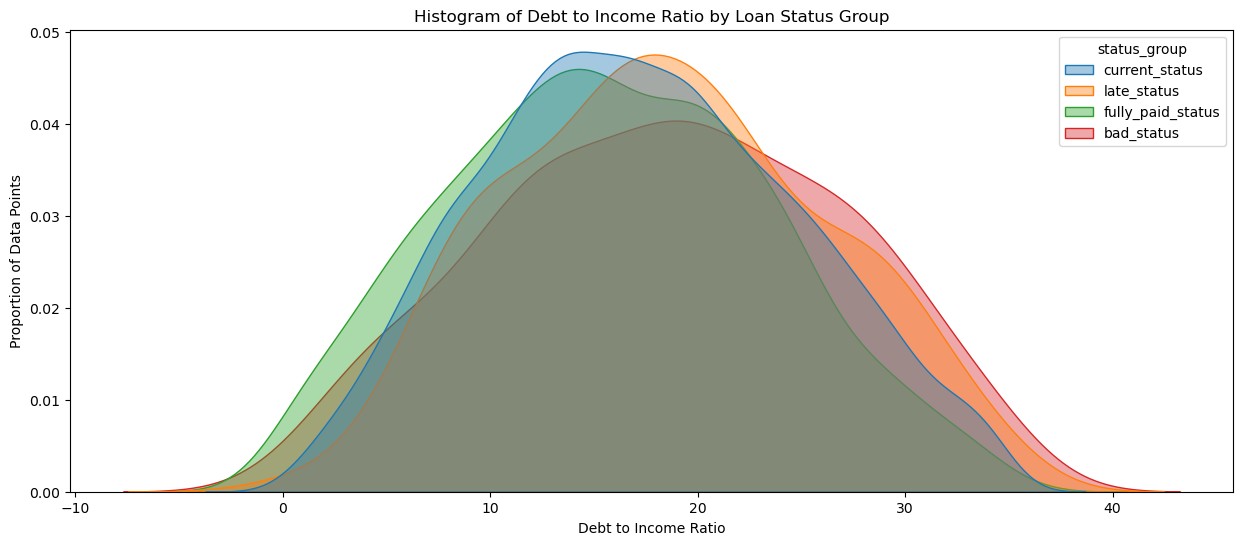

In [899]:
# agg_df = input_df.copy()
# agg_df['annual_inc_log'] = np.log(agg_df['annual_inc'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=input_df, x="dti", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Debt to Income Ratio by Loan Status Group')
plt.show()


Higher DTI have tend to have bad and late status in loans 

## Histogram of Revolving Balance by Loan Status Group

/Users/psantanu/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


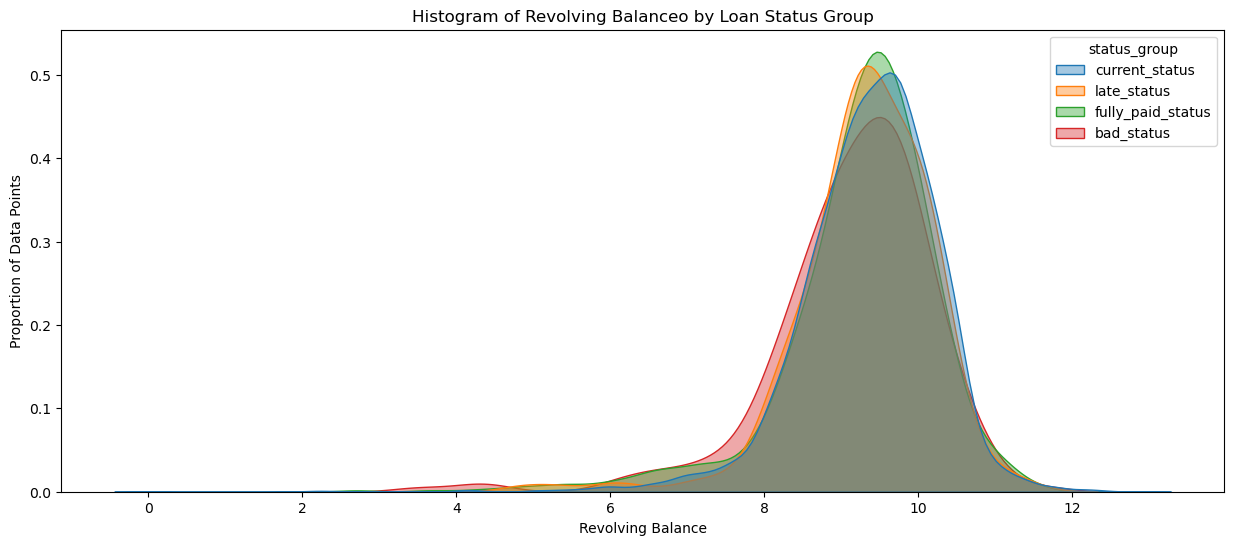

In [900]:
agg_df = input_df.copy()
agg_df['revol_bal_log'] = np.log(agg_df['revol_bal'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=agg_df, x="revol_bal_log", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Revolving Balance')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Revolving Balanceo by Loan Status Group')
plt.show()


Bad status loans tend to have marginally lower revolving balance

In [901]:
# Current Loans Outstanding payments
input_df['outstanding_payment'] = input_df['installment']*input_df['term'].apply(lambda row: int(row.replace('months', '').replace(' ', ''))) - input_df['total_pymnt']
input_df['outstanding_interest'] = input_df['outstanding_payment'] - input_df['out_prncp']

input_df.groupby(['status_group'], as_index = False).agg({'outstanding_payment': 'sum',
                                                         'out_prncp': 'sum',
                                                         'outstanding_interest': 'sum'})

,status_group,outstanding_payment,out_prncp,outstanding_interest
0,bad_status,3.525199e+06,234275.02,3.290924e+06
1,current_status,1.207360e+08,94740945.77,2.599504e+07
2,fully_paid_status,2.885961e+06,0.00,2.885961e+06
3,late_status,3.600685e+06,2680772.57,9.199125e+05


# 2. Develop a Model to Identify a Good or Bad Loan

In [902]:
input_df['earliest_cr_line'] = pd.to_datetime(input_df['earliest_cr_line'])
input_df['days_to_cr'] = (input_df['earliest_cr_line'].apply(lambda row: datetime.now() - row)).dt.days

model_df = input_df[input_df['status_group'].isin(['fully_paid_status', 'bad_status'])]
model_df['target_label'] = model_df['status_group'].apply(lambda row: 1 if row == 'bad_status' else 0)
print(model_df.shape)
a = model_df['target_label'].value_counts()

print('Total number of records in the model base data >>> ', model_df.shape[0])
print('% of 1s (bad loans) in the data >>> ', a[1]/model_df.shape[0])

(1185, 34)
Total number of records in the model base data >>>  1185
% of 1s (bad loans) in the data >>>  0.19746835443037974


/var/folders/4p/8cq2kdh926l68b28541247jr0000gr/T/ipykernel_15932/582035638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['target_label'] = model_df['status_group'].apply(lambda row: 1 if row == 'bad_status' else 0)


There is class imbalance in the dataset with only 20% as 1s. Need to account for that while building the model

## Features to be Used

Total and outstanding payments features are removed since for a loan which is already good outstanding payments is 0. These features will fully explain the model. For a new loan data, a loan with outstanding payment can go on to becoming a good loan. Hence, we have removed these features from the model

In [903]:
feat_list = list(input_df.columns)
drop_feats = ['id', 'loan_amnt', 'wtd_loans', 'interest_rate', 'int_rate2', 'target_label', 'out_prncp',
             'num_rate', 'numrate', 'int_rate3', 'status_group', 'loan_status', 'earliest_cr_line', 'addr_state',
             'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'outstanding_payment', 'outstanding_interest']

feat_list = [col for col in feat_list if col not in drop_feats]
print('Feature List >>> ')
feat_list

Feature List >>> 


['funded_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'open_acc',
 'revol_bal',
 'total_acc',
 'days_to_cr']

## One Hot Encoding

In [904]:
dtype_df = model_df[feat_list].dtypes
print('Features that need to be one-hot-encoded >>> ')
char_feats = list(dtype_df[dtype_df == 'object'].index)
char_feats

Features that need to be one-hot-encoded >>> 


['term', 'emp_length', 'home_ownership', 'purpose']

In [905]:
model_df = pd.get_dummies(model_df, columns = char_feats)

model_df.rename(columns = {'emp_length_10+ years': 'emp_length_10plus_years',
                          'emp_length_< 1 year': 'emp_length_less_1_year'},
               inplace = True)

In [906]:
feat_list = list(model_df.columns)
drop_feats = drop_feats + char_feats
drop_feats

['id',
 'loan_amnt',
 'wtd_loans',
 'interest_rate',
 'int_rate2',
 'target_label',
 'out_prncp',
 'num_rate',
 'numrate',
 'int_rate3',
 'status_group',
 'loan_status',
 'earliest_cr_line',
 'addr_state',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int',
 'outstanding_payment',
 'outstanding_interest',
 'term',
 'emp_length',
 'home_ownership',
 'purpose']

In [907]:
feat_list = [col for col in feat_list if col not in drop_feats]
print('New Feature List After  >>> ')
feat_list

New Feature List After  >>> 


['funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'open_acc',
 'revol_bal',
 'total_acc',
 'days_to_cr',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10plus_years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_less_1_year',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [1033]:
feat_list

['funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'open_acc',
 'revol_bal',
 'total_acc',
 'days_to_cr',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10plus_years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_less_1_year',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

## Split into Train and Test

80-20 split is taken since we are already dealing with low sample size (1,185)

In [908]:
train_samp_pct = 0.8
label = 'target_label'

In [909]:

msk = np.random.rand(model_df.shape[0]) <= train_samp_pct
train_val_df = model_df[msk]

test_df = model_df[~msk] 

print(train_val_df.shape)
print(test_df.shape)

(949, 59)
(236, 59)


## Run XGBoost: Random Search Hyperparameter Optimization

We are using random search hyperparameter optimization technique. We are optimzing for F1 (reason later explained)

In [957]:
%%time

# Number of trees 
n_estimators = [100, 200, 300, 400, 500]
# fraction of features (randomly selected) that will be used to train each tree.
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Maximum number of levels in tree
max_depth = [3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
# Minimum loss reduction required to make a further partition on a leaf node of the tree.
gamma = [0.1, 0.3, 0.5, 0.8]
# Regularization constant
learning_rate = [0.001, 0.003, 0.005, 0.01]
wts = [1, 5, 7, 10, 12]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'colsample_bytree': colsample_bytree,
               'max_depth': max_depth,
               'gamma': gamma,
               'learning_rate': learning_rate,
#                'eval_metric': ['auc'],
              'subsample': [0.5, 0.8],
              'objective': ['binary:logistic'],
#                'warm_start': ['True'],
               'scale_pos_weight': wts
              }
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb_class = xgb.XGBClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb_class, param_distributions = random_grid, n_iter = 200, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'f1')

# Fit the random search model
xgb_random.fit(train_val_df[feat_list], train_val_df[label])


{'n_estimators': [100, 200, 300, 400, 500], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100], 'gamma': [0.1, 0.3, 0.5, 0.8], 'learning_rate': [0.001, 0.003, 0.005, 0.01], 'subsample': [0.5, 0.8], 'objective': ['binary:logistic'], 'scale_pos_weight': [1, 5, 7, 10, 12]}
Fitting 3 folds for each of 200 candidates, totalling 600 fits
CPU times: user 7.44 s, sys: 312 ms, total: 7.76 s
Wall time: 49.7 s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.1, 0.3, 0.5, 0.8],
                                        'learning_rate': [0.001, 0.003, 0.005,
                                                          0.01],
                                        'max_depth': [3, 5, 10, 15, 20, 25, 30,
                                                      40, 50, 60, 80, 100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'objective': ['binary:logistic'],
                                        'scale_pos_weight': [1, 5, 7, 10, 12],
                                        'subsample': [0.5, 0.8]},
                   random_state=42, scoring='f1', verbose=2)

## Best Model

In [958]:
xgb_random.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 7,
 'objective': 'binary:logistic',
 'n_estimators': 400,
 'max_depth': 10,
 'learning_rate': 0.001,
 'gamma': 0.5,
 'colsample_bytree': 0.9}

In [959]:
# xg_best = xgb_random.best_estimator_
# xg_best

In [960]:

xg_reg = xgb_random.best_estimator_

random.seed(124)
xg_reg.fit(train_val_df[feat_list], train_val_df[label])

train_auc = (roc_auc_score(train_val_df[label], xg_reg.predict_proba(train_val_df[feat_list])[:,1]))  
test_auc = (roc_auc_score(test_df[label], xg_reg.predict_proba(test_df[feat_list])[:,1]))

print(train_auc, test_auc)



0.9940037566825604 0.7295482295482295


## Distibution of Train and Test Scores

/var/folders/4p/8cq2kdh926l68b28541247jr0000gr/T/ipykernel_15932/3885144738.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a[0]);


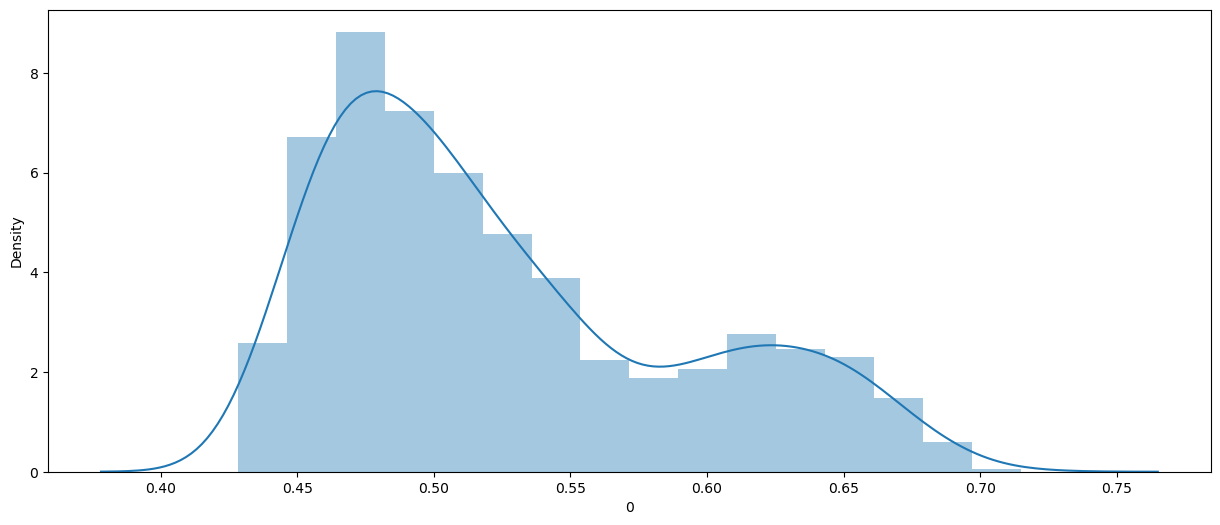

In [961]:
a = pd.DataFrame(xg_reg.predict_proba(train_val_df[feat_list])[:,1])
plt.figure(figsize=(15, 6))
sns.distplot(a[0]);

/var/folders/4p/8cq2kdh926l68b28541247jr0000gr/T/ipykernel_15932/770141464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a[0]);


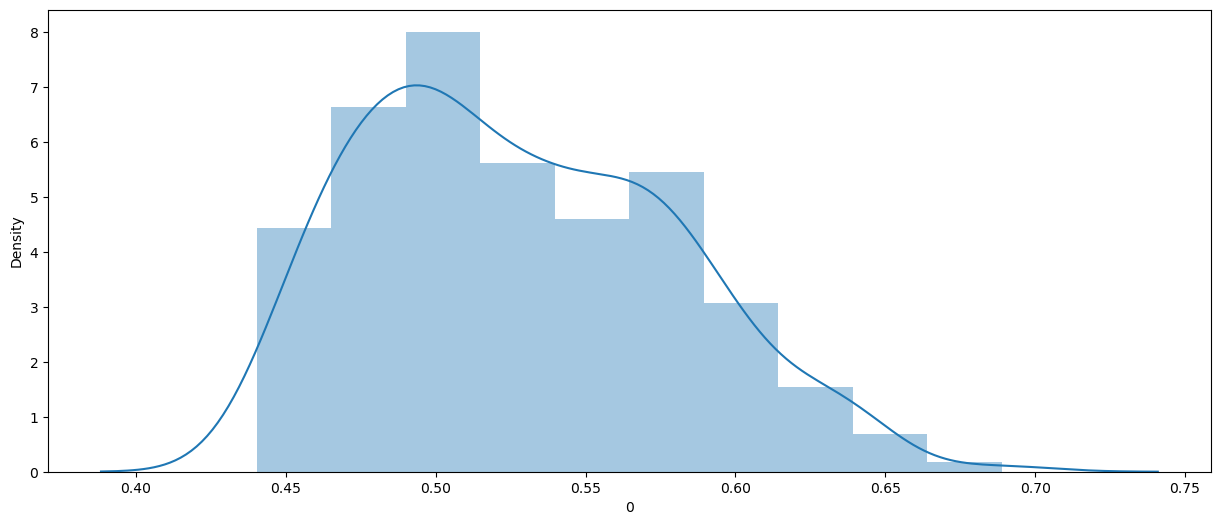

In [962]:
a = pd.DataFrame(xg_reg.predict_proba(test_df[feat_list])[:,1])
plt.figure(figsize=(15, 6))
sns.distplot(a[0]);


This is the final model we will use

## Evaluation of the Model

Model will be evaluated based on the following metrics:

1. Precision and Recall: We want to minimize false negative since we do not want to label a loan as "good", and it ends up becoming a bad loan in future. On the other hand, we want to minimize false positives since they represent missed opportunitites. We need to strike a balance between precision and recall, hence we have maximized F1 score.

2. AUC: This will help us understand the rank order of the model scores. That is, one loan which has higher probability of becoming bad should have higher score than another loan with lower probability of becoming bad.

3. Cumulative Lift Chart: This will give us an idea of % of actual bad loans we can treat by reaching out to top nth percentile of loans based on model scores

In [963]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
import seaborn as sns
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

In [964]:
class lift_metrics:
    
    def __init__(self, y_df, x_df, _model):
        self.y_df = y_df
        self.x_df = x_df
        self._model = _model
        
    def create_lift_df(self):
        
        temp = pd.DataFrame(self._model.predict_proba(self.x_df)[:,1])
        actual = pd.DataFrame(self.y_df)
        actual.reset_index(inplace=True, drop = True)
        temp = pd.concat([temp, actual], axis = 1)
        temp.columns = ['Pred_Prob', 'Actual_Label']
        temp.sort_values(by = 'Pred_Prob', ascending = False, inplace = True)
        temp['Pred_Prob_Decile'] = pd.qcut(temp['Pred_Prob'].rank(method='first'), 10, labels = np.arange(10, 0, -1))
        temp2 = temp.groupby(['Pred_Prob_Decile'], as_index=False).agg({'Actual_Label': ['count', 'sum', 'mean']})
        temp2.sort_values(by = 'Pred_Prob_Decile', inplace = True, ascending=False)
        temp2['respond_cum'] = temp2['Actual_Label']['sum'].cumsum()
        temp2['respond_cum_pct'] = temp2['respond_cum'] / temp2['Actual_Label']['sum'].sum()
        
        return temp2
    
    def return_decile(self, n):
        
        lift_df = self.create_lift_df()
        
        return lift_df[lift_df['Pred_Prob_Decile'] == n]['respond_cum_pct'].values[0]
    

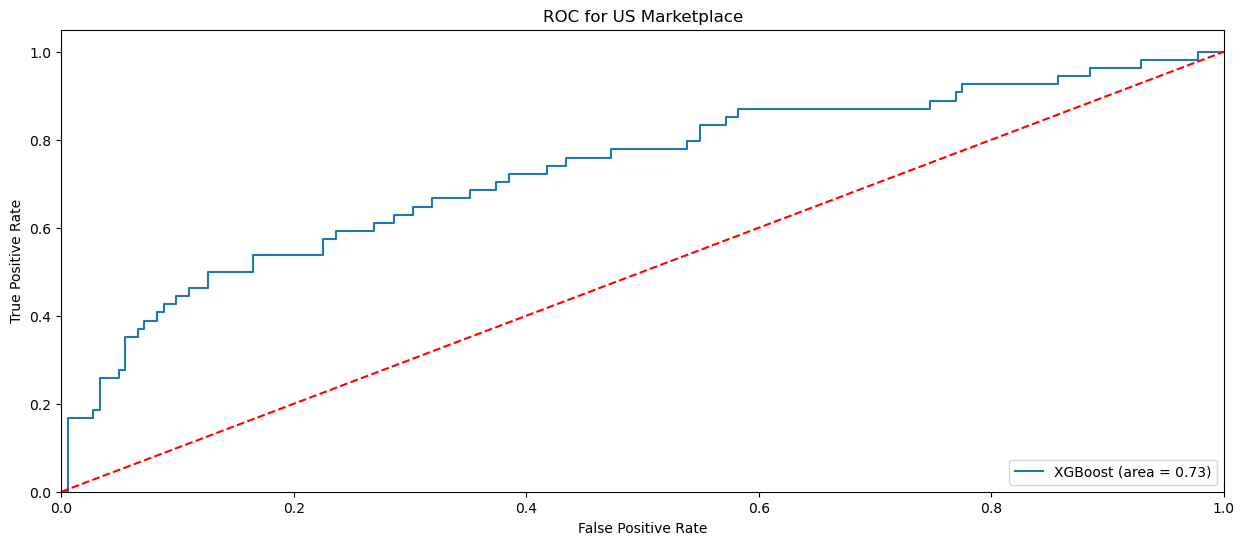

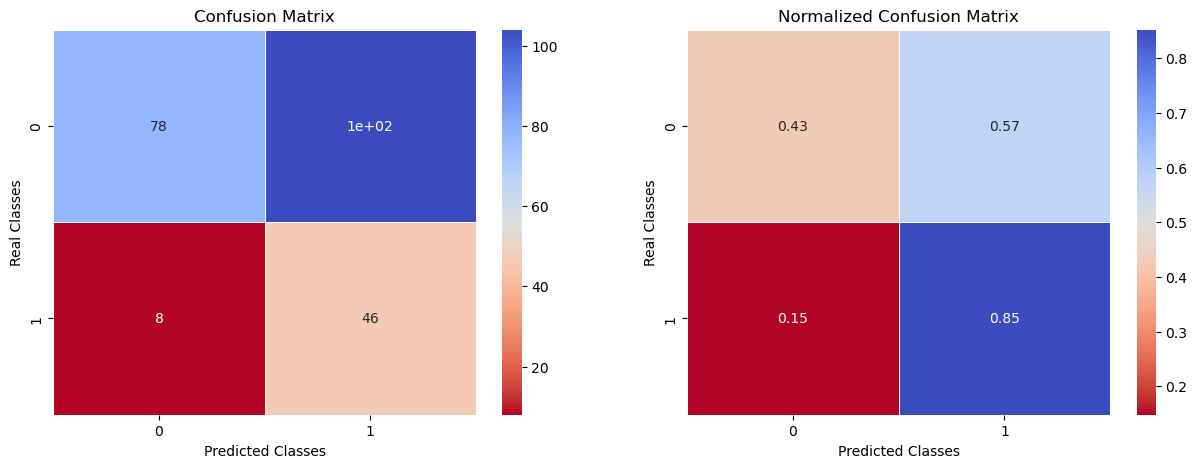

---Classification Report---
              precision    recall  f1-score   support

           0       0.91      0.43      0.58       182
           1       0.31      0.85      0.45        54

    accuracy                           0.53       236
   macro avg       0.61      0.64      0.52       236
weighted avg       0.77      0.53      0.55       236



,Pred_Prob_Decile,Obs,Respond_sum,respond_mean,respond_cum,respond_cum_pct,baseline_respond,baseline_respond_cum
9,1,24,15,0.625000,15,0.277778,0.1,0.1
8,2,23,10,0.434783,25,0.462963,0.1,0.2
7,3,24,5,0.208333,30,0.555556,0.1,0.3
6,4,23,6,0.260870,36,0.666667,0.1,0.4
5,5,24,4,0.166667,40,0.740741,0.1,0.5
4,6,23,3,0.130435,43,0.796296,0.1,0.6
3,7,24,4,0.166667,47,0.870370,0.1,0.7
2,8,23,1,0.043478,48,0.888889,0.1,0.8
1,9,24,3,0.125000,51,0.944444,0.1,0.9
0,10,24,3,0.125000,54,1.000000,0.1,1.0


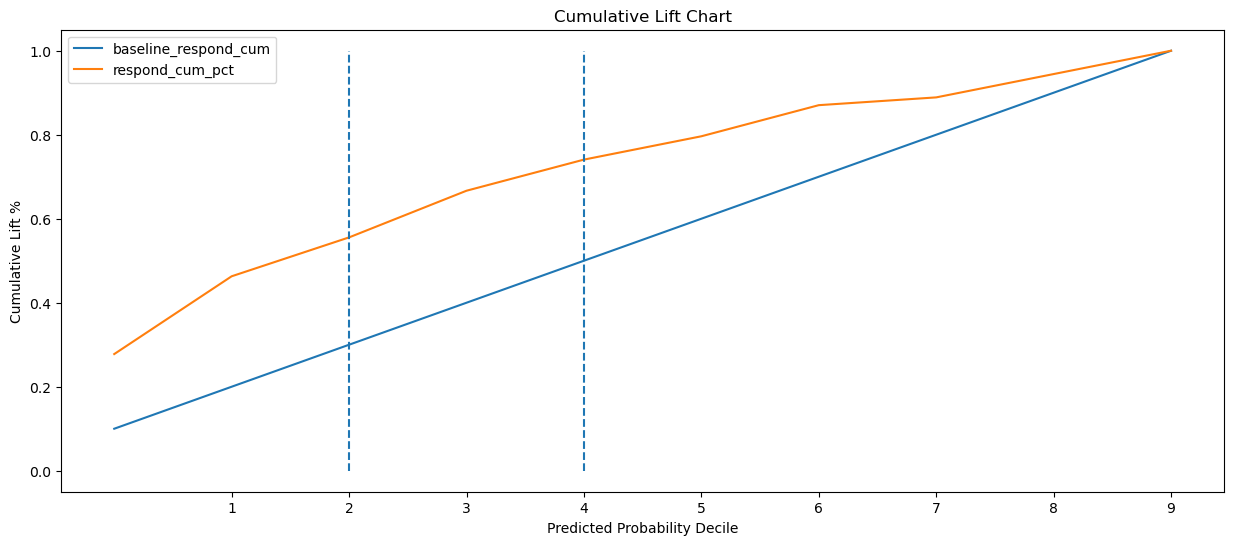

In [965]:
fpr, tpr, thresholds = roc_curve(test_df[label], xg_reg.predict_proba(test_df[feat_list])[:,1])
plt.figure(figsize = (15, 6))
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for US Marketplace')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

pred = xg_reg.predict(test_df[feat_list])
y_train_no = train_val_df[label].shape[0] - train_val_df[label].sum()
y_train_yes = train_val_df[label].sum()
y_test_no = test_df[label].shape[0] - test_df[label].sum()
y_test_yes = test_df[label].sum()

PlotConfusionMatrix(test_df[label],pred,y_test_no,y_test_yes)

cum_lift_class = lift_metrics(test_df[label], test_df[feat_list], xg_reg) # Instantiate the class
lift_df = cum_lift_class.create_lift_df()

lift_df['baseline_respond'] = 1/lift_df.shape[0]
lift_df['baseline_respond_cum'] = lift_df['baseline_respond'].cumsum()

lift_df.columns = ['Pred_Prob_Decile', 'Obs', 'Respond_sum', 'respond_mean', 'respond_cum', 'respond_cum_pct', 'baseline_respond',
                  'baseline_respond_cum']


lift_df.plot(x="Pred_Prob_Decile", y=["baseline_respond_cum", "respond_cum_pct"], 
                               kind="line", figsize = (15, 6))

plt.xticks(np.arange(1, 11, step=1), np.arange(1, 11, step=1))
plt.vlines(x = [2, 4], ymin = 0, ymax = 1, linestyle="dashed")
plt.ylabel('Cumulative Lift %')
plt.xlabel('Predicted Probability Decile')
plt.title('Cumulative Lift Chart')

lift_df

## Result: Recall of the model is 85%, Precision 31%, F1 score 45%. AUC is 73%. And cumulative lift % in 5th decile (targeting top 50% of loans based on model scores) is 73%

## Feature Importances

Using Permutation method which shuffles the values of individual feature in the trained model and looks at the change in the accuracy. This is more robust than standard XGBoost feature importance in the case where there is overfitting. 

In [484]:

feat_imp_dict = permutation_importance(xg_reg, train_val_df[feat_list], train_val_df[label],
                            n_repeats=30,
                            random_state=0)

feat_imp_df = pd.concat([pd.DataFrame(feat_list),
                         pd.DataFrame(feat_imp_dict['importances_mean']), 
                         pd.DataFrame(feat_imp_dict['importances_std'])], axis = 1)


feat_imp_df.columns = ['feat_name', 'feat_imp_score_mean', 'feat_imp_score_stddev']
feat_imp_df.sort_values(by = 'feat_imp_score_mean', ascending = False)

,feat_name,feat_imp_score_mean,feat_imp_score_stddev
3,annual_inc,0.036520,0.005622
1,int_rate,0.029377,0.004411
8,revol_bal,0.025630,0.003982
4,dti,0.023529,0.003052
11,days_to_cr,0.021289,0.003546
0,funded_amnt,0.013235,0.002878
2,installment,0.010714,0.002784
9,total_acc,0.009069,0.003991
10,out_prncp,0.007563,0.002142
7,open_acc,0.006933,0.002652


Followig are top 5 features which have highest impact on "bad" loan:

Annual Income: Lower annual income, higher chances for loan to go bad

Interest Rate: HIgher interest rate, higher the chances of a loan to go bad

Revolving Balance:  

Debt to Income Ratio: 

Age of Credit Line (When borrower started their first credit)

Funded Amount
    

Let's plot simple bivariate graphs to see the relationships. 

## Bivariate analysis: Loan Status vs. Annual Income 

Raw Table  >>> 
  annual_inc_bucket     annual_inc  num_loans  num_loans_bad  loans_bad_rate
0                 0   26687.235294        119             43        0.361345
1                 1   37253.462712        118             39        0.330508
2                 2   44001.000252        119             29        0.243697
3                 3   51049.444322        118             16        0.135593
4                 4   57076.596639        119             24        0.201681
5                 5   63509.580678        118             18        0.152542
6                 6   72301.016949        118             17        0.144068
7                 7   83751.367395        119             18        0.151261
8                 8   99235.547712        118             17        0.144068
9                 9  174274.442269        119             13        0.109244


Text(0.5, 1.0, 'Bad Loans Rate by Average Annual Income')

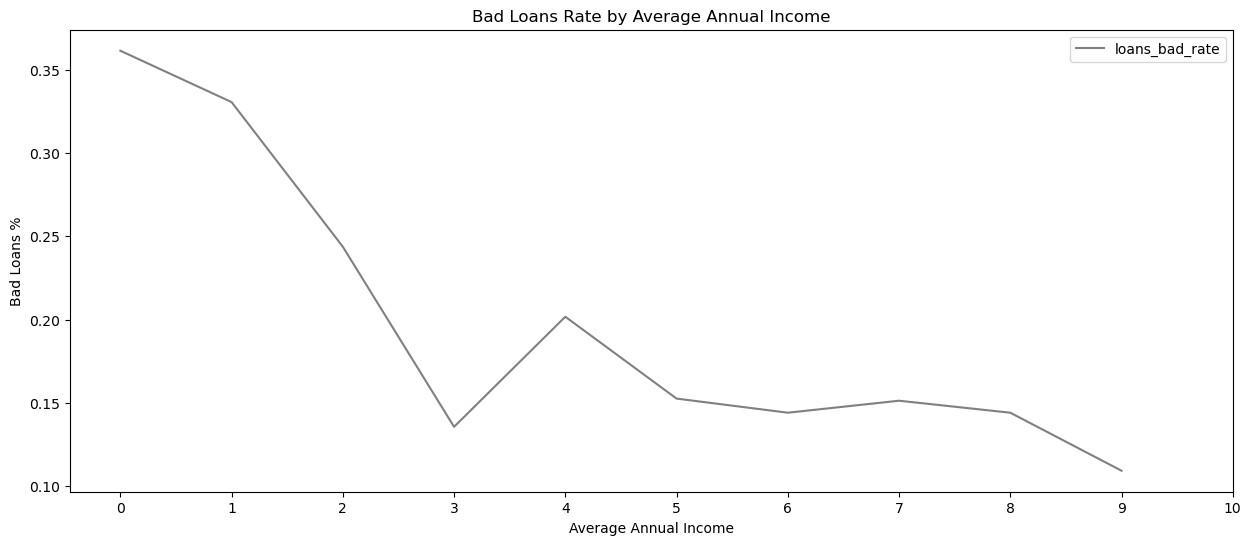

In [491]:
agg_df = model_df.copy()


agg_df['annual_inc_bucket'] = pd.qcut(agg_df['annual_inc'].rank(method='first'), 10, np.arange(10))
agg_df = agg_df.groupby(['annual_inc_bucket'], as_index = False).agg({'annual_inc': ['mean'],
                                                        label: ['count', 'sum']})
agg_df.columns = ['annual_inc_bucket', 'annual_inc', 'num_loans', 'num_loans_bad']
agg_df['loans_bad_rate'] = agg_df['num_loans_bad'] / agg_df['num_loans']

print('Raw Table  >>> \n{}'.format(agg_df))

agg_df.plot(x = 'annual_inc_bucket', y = 'loans_bad_rate', figsize = (15, 6), linestyle='-', color = 'grey')
plt.xticks(np.arange(11), np.arange(11))
plt.xlabel('Average Annual Income')
plt.ylabel('Bad Loans %')
plt.title('Bad Loans Rate by Average Annual Income')

From bivariate analysis, we clearly find that as average annual income increases, chances of bad loans decreases. This is in line with our earlier exploratory analysis

## Bivariate analysis: Interest Rate vs. Loan Status

Raw Table  >>> 
  int_rate_bucket   int_rate  num_loans  num_loans_bad  loans_bad_rate
0               0   6.951261        119             11        0.092437
1               1   8.862797        118             12        0.101695
2               2  11.139160        119             13        0.109244
3               3  12.399153        118             28        0.237288
4               4  13.470000        119             22        0.184874
5               5  14.395763        118             22        0.186441
6               6  15.698814        118             26        0.220339
7               7  17.251513        119             24        0.201681
8               8  19.119661        118             37        0.313559
9               9  22.521597        119             39        0.327731


Text(0.5, 1.0, 'Bad Loans Rate by Average Interest Rate')

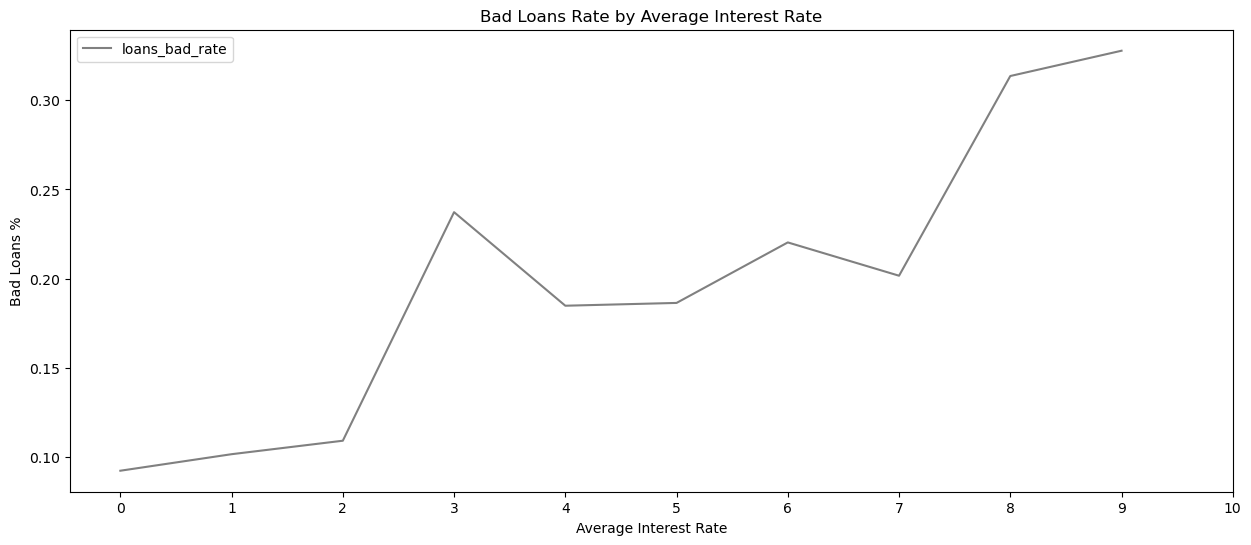

In [492]:
agg_df = model_df.copy()


agg_df['int_rate_bucket'] = pd.qcut(agg_df['int_rate'].rank(method='first'), 10, np.arange(10))
agg_df = agg_df.groupby(['int_rate_bucket'], as_index = False).agg({'int_rate': ['mean'],
                                                        label: ['count', 'sum']})
agg_df.columns = ['int_rate_bucket', 'int_rate', 'num_loans', 'num_loans_bad']
agg_df['loans_bad_rate'] = agg_df['num_loans_bad'] / agg_df['num_loans']

print('Raw Table  >>> \n{}'.format(agg_df))

agg_df.plot(x = 'int_rate_bucket', y = 'loans_bad_rate', figsize = (15, 6), linestyle='-', color = 'grey')
plt.xticks(np.arange(11), np.arange(11))
plt.xlabel('Average Interest Rate')
plt.ylabel('Bad Loans %')
plt.title('Bad Loans Rate by Average Interest Rate')

From bivariate analysis, we clearly find that as average interest rate increases, chances of bad loans also increases. This is in line with our earlier exploratory analysis

## Bivariate analysis: Revolving Balance vs. Loan Status

Raw Table  >>> 
  revol_bal_bucket     revol_bal  num_loans  num_loans_bad  loans_bad_rate
0                0   2947.358650        237             55        0.232068
1                1   7666.464135        237             50        0.210970
2                2  11790.113924        237             42        0.177215
3                3  17058.915612        237             47        0.198312
4                4  33367.151899        237             40        0.168776


Text(0.5, 1.0, 'Bad Loans Rate by Average Revolving Balance')

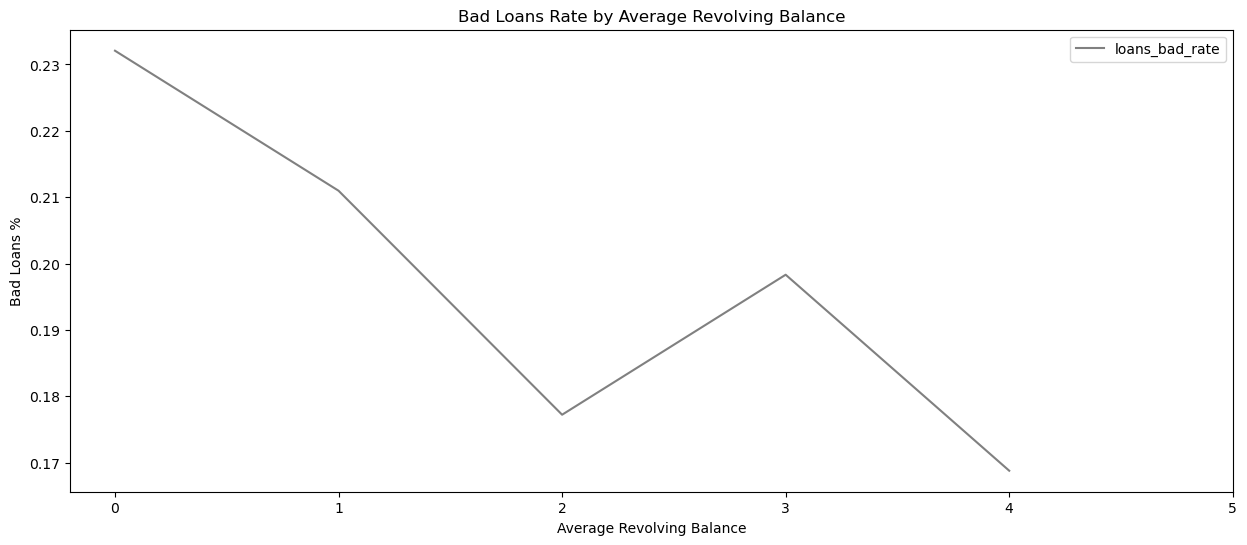

In [718]:
agg_df = model_df.copy()


agg_df['revol_bal_bucket'] = pd.qcut(agg_df['revol_bal'].rank(method='first'), 5, np.arange(5))
agg_df = agg_df.groupby(['revol_bal_bucket'], as_index = False).agg({'revol_bal': ['mean'],
                                                        label: ['count', 'sum']})
agg_df.columns = ['revol_bal_bucket', 'revol_bal', 'num_loans', 'num_loans_bad']
agg_df['loans_bad_rate'] = agg_df['num_loans_bad'] / agg_df['num_loans']

print('Raw Table  >>> \n{}'.format(agg_df))

agg_df.plot(x = 'revol_bal_bucket', y = 'loans_bad_rate', figsize = (15, 6), linestyle='-', color = 'grey')
plt.xticks(np.arange(6), np.arange(6))
plt.xlabel('Average Revolving Balance')
plt.ylabel('Bad Loans %')
plt.title('Bad Loans Rate by Average Revolving Balance')

From bivariate analysis, we don't see strict linear relationship between revolving balance and bad loan %. HOwever, it seems like as revolving balance increases, the chances of bad loan are lower. This sounds a bit counterintuitive, since high revolving balance means borrower is relying too much on credit. 

## Bivariate analysis: Loan Status vs. Debt to Income Ratio

Raw Table  >>> 
  dti_bucket  revol_bal  num_loans  num_loans_bad  loans_bad_rate
0          0   3.182689        119             18        0.151261
1          1   7.367458        118             14        0.118644
2          2  10.394202        119             22        0.184874
3          3  12.796525        118             21        0.177966
4          4  14.968739        119             14        0.117647
5          5  17.258644        118             27        0.228814
6          6  19.653390        118             24        0.203390
7          7  21.974202        119             21        0.176471
8          8  24.920847        118             30        0.254237
9          9  30.141597        119             43        0.361345


Text(0.5, 1.0, 'Bad Loans Rate by Average DTI')

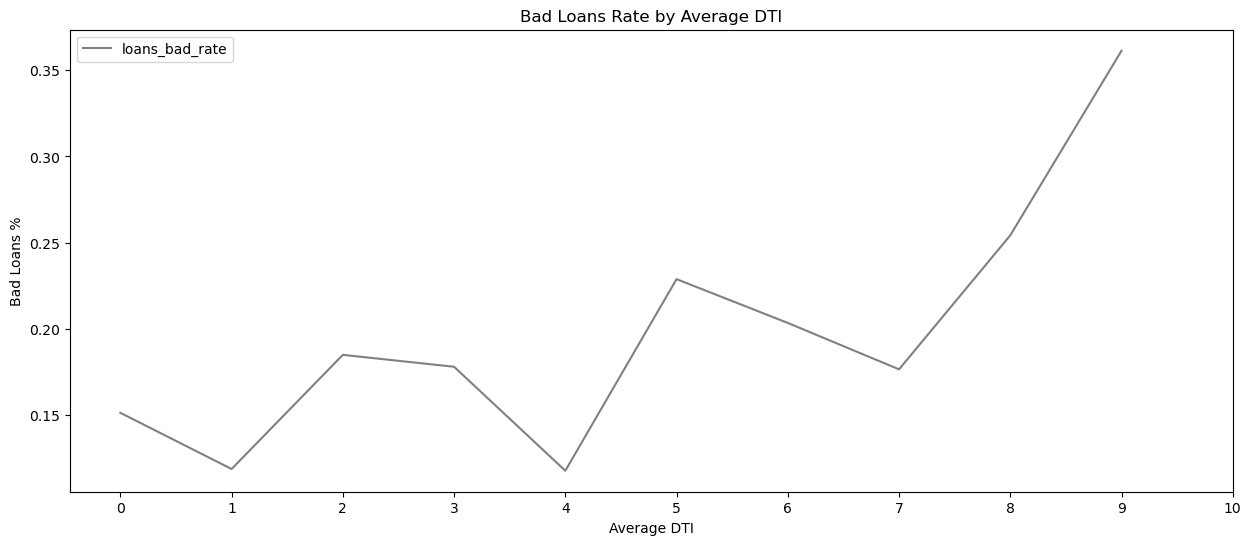

In [494]:
agg_df = model_df.copy()


agg_df['dti_bucket'] = pd.qcut(agg_df['dti'].rank(method='first'), 10, np.arange(10))
agg_df = agg_df.groupby(['dti_bucket'], as_index = False).agg({'dti': ['mean'],
                                                        label: ['count', 'sum']})
agg_df.columns = ['dti_bucket', 'revol_bal', 'num_loans', 'num_loans_bad']
agg_df['loans_bad_rate'] = agg_df['num_loans_bad'] / agg_df['num_loans']

print('Raw Table  >>> \n{}'.format(agg_df))

agg_df.plot(x = 'dti_bucket', y = 'loans_bad_rate', figsize = (15, 6), linestyle='-', color = 'grey')
plt.xticks(np.arange(11), np.arange(11))
plt.xlabel('Average DTI')
plt.ylabel('Bad Loans %')
plt.title('Bad Loans Rate by Average DTI')

From bivariate analysis, we clearly find that as average DTI increases, chances of bad loans also increases. This is in line with our earlier exploratory analysis.

## Bivariate analysis: Loan Status vs. Age of Credit Line

Raw Table  >>> 
  days_to_cr_bucket     revol_bal  num_loans  num_loans_bad  loans_bad_rate
0                 0   6603.177215        237             61        0.257384
1                 1   8016.784810        237             36        0.151899
2                 2   8953.590717        237             49        0.206751
3                 3  10135.518987        237             50        0.210970
4                 4  12943.493671        237             38        0.160338


Text(0.5, 1.0, 'Bad Loans Rate by Average Age of Credit')

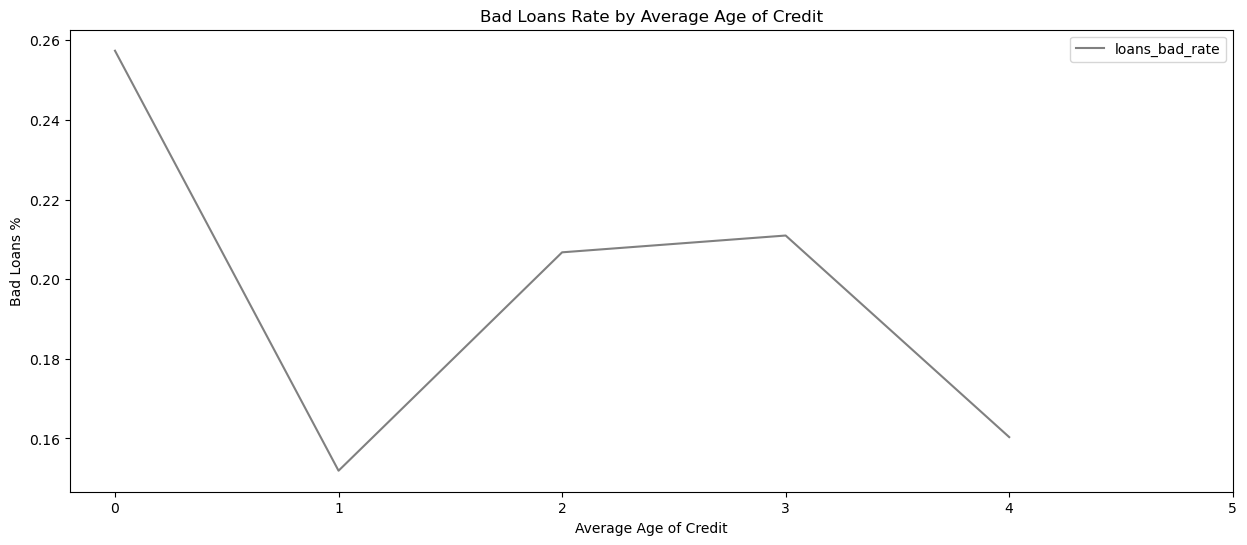

In [498]:
agg_df = model_df.copy()


agg_df['days_to_cr_bucket'] = pd.qcut(agg_df['days_to_cr'].rank(method='first'), 5, np.arange(5))
agg_df = agg_df.groupby(['days_to_cr_bucket'], as_index = False).agg({'days_to_cr': ['mean'],
                                                        label: ['count', 'sum']})
agg_df.columns = ['days_to_cr_bucket', 'revol_bal', 'num_loans', 'num_loans_bad']
agg_df['loans_bad_rate'] = agg_df['num_loans_bad'] / agg_df['num_loans']

print('Raw Table  >>> \n{}'.format(agg_df))

agg_df.plot(x = 'days_to_cr_bucket', y = 'loans_bad_rate', figsize = (15, 6), linestyle='-', color = 'grey')
plt.xticks(np.arange(6), np.arange(6))
plt.xlabel('Average Age of Credit')
plt.ylabel('Bad Loans %')
plt.title('Bad Loans Rate by Average Age of Credit')

From bivariate analysis, we do not see a linear relationship between age of credit and bad loan percentage. But, it seems like new credit accounts have higher chances of going bad vs. older credit accounts

## Current Risk Analysis: Use the model to score current

We are given loans which have current status. Let's use the model to score these loans to know more about current risk portfolio.

How many loans are going to be good and bad in current and late loans?

In [967]:
curr_df = input_df[input_df['status_group'] == 'current_status']
curr_df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,...,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3,status_group,outstanding_payment,outstanding_interest,days_to_cr
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,...,NaN,NaN,10.16%,NaN,NaN,10.16,current_status,15758.43,2495.25,10181
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,...,NaN,NaN,8.90%,NaN,NaN,8.90,current_status,17421.86,2127.61,10810
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,...,NaN,NaN,15.80%,NaN,NaN,15.80,current_status,5165.42,734.83,9372
6,1042871,6250,6250,36 months,7.51,194.45,7 years,MORTGAGE,33600.0,Current,...,NaN,NaN,7.51%,NaN,NaN,7.51,current_status,2152.95,80.40,6664
7,1055193,7300,7300,36 months,13.49,247.70,3 years,RENT,50000.0,Current,...,NaN,NaN,13.49%,NaN,NaN,13.49,current_status,2731.70,177.10,6521


## One Hot Encoding

In [970]:
curr_df = pd.get_dummies(curr_df, columns = char_feats)

curr_df.rename(columns = {'emp_length_10+ years': 'emp_length_10plus_years',
                          'emp_length_< 1 year': 'emp_length_less_1_year'},
               inplace = True)

## Scoring

/var/folders/4p/8cq2kdh926l68b28541247jr0000gr/T/ipykernel_15932/196993904.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored_df['pred_score']);


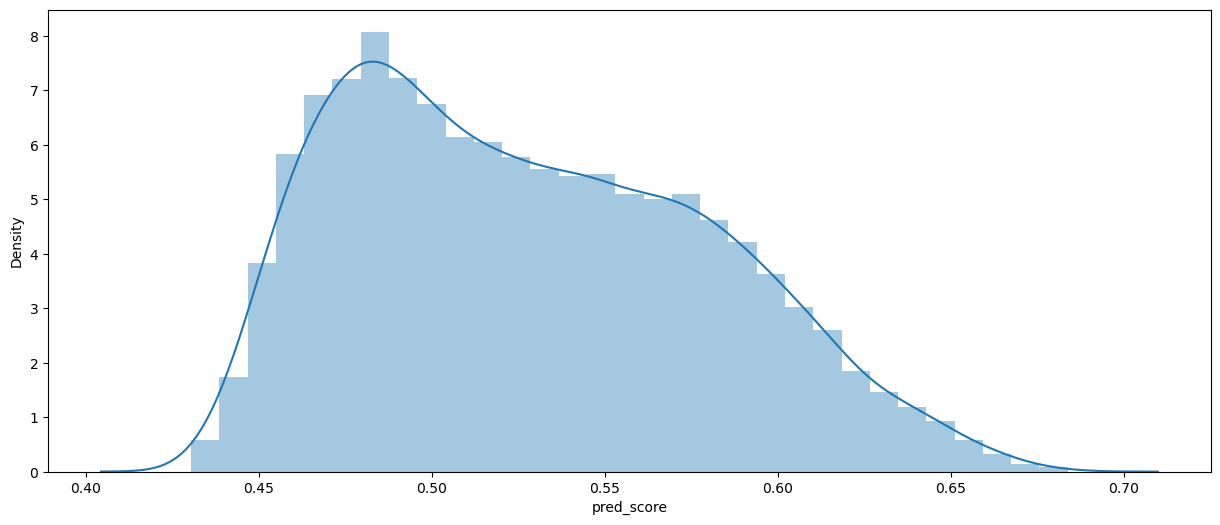

In [972]:
scored_df = pd.DataFrame(xg_reg.predict_proba(curr_df[feat_list])[:,1])
scored_df.columns = ['pred_score']

plt.figure(figsize=(15, 6))
sns.distplot(scored_df['pred_score']);

pred =  pd.DataFrame(xg_reg.predict(curr_df[feat_list]))
pred.columns = ['pred_flag']

curr_df.reset_index(drop = True, inplace = True)

curr_df = pd.concat([curr_df, scored_df, pred], axis = 1)

We see the distribution of probability scores are skewed towards right, implying most of the loans in current portfolio have higher chances of going bad.

In [984]:
print('Total number of loans in current protfolio >>> ', curr_df.shape[0])
print('Estimated number of loans which have current status but are likely to go bad (according to the model) in future are >>> ', curr_df['pred_flag'].sum(), curr_df['pred_flag'].sum()/curr_df.shape[0])
print('Out of the estimated loans which are likely to go bad ({0}), around 31% are actually likely to go bad (precision of the model)'.format(curr_df['pred_flag'].sum(), ))
print('Hence, out of the loands which are predicted to go bad by the model, {0} are actually going to be bad'.format(curr_df['pred_flag'].sum()*0.31))

Total number of loans in current protfolio >>>  8122
Estimated number of loans which have current status but are likely to go bad (according to the model) in future are >>>  5125 0.6310022162029056
Out of the estimated loans which are likely to go bad (5125), around 31% are actually likely to go bad (precision of the model)
Hence, out of the loands which are predicted to go bad by the model, 1588.75 are actually going to be bad


## Why so many loans are predicted "bad" in current?

Compare the disributions of important features in fully repaid loans vs. current loans

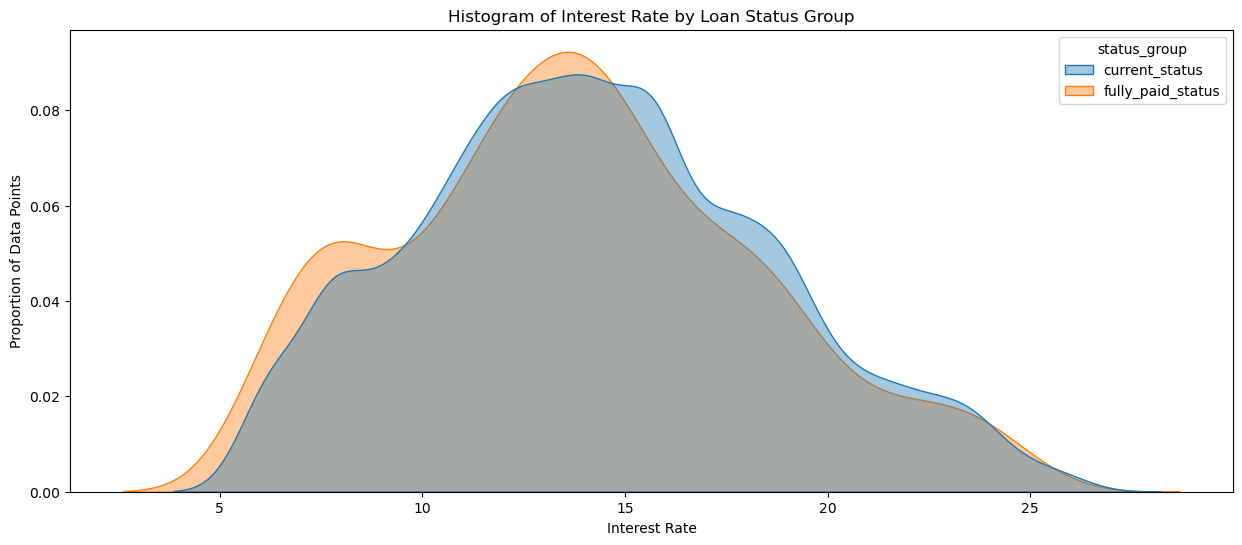

In [1005]:
# agg_df = combined_df.copy()
# agg_df['annual_inc_log'] = np.log(agg_df['annual_inc'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=combined_df, x="int_rate", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Interest Rate')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Interest Rate by Loan Status Group')
plt.show()


Interest Rate of current loans seem to be higher than fully paid loans. From the model, we know that Interest rate is a top driver for loan going bad.

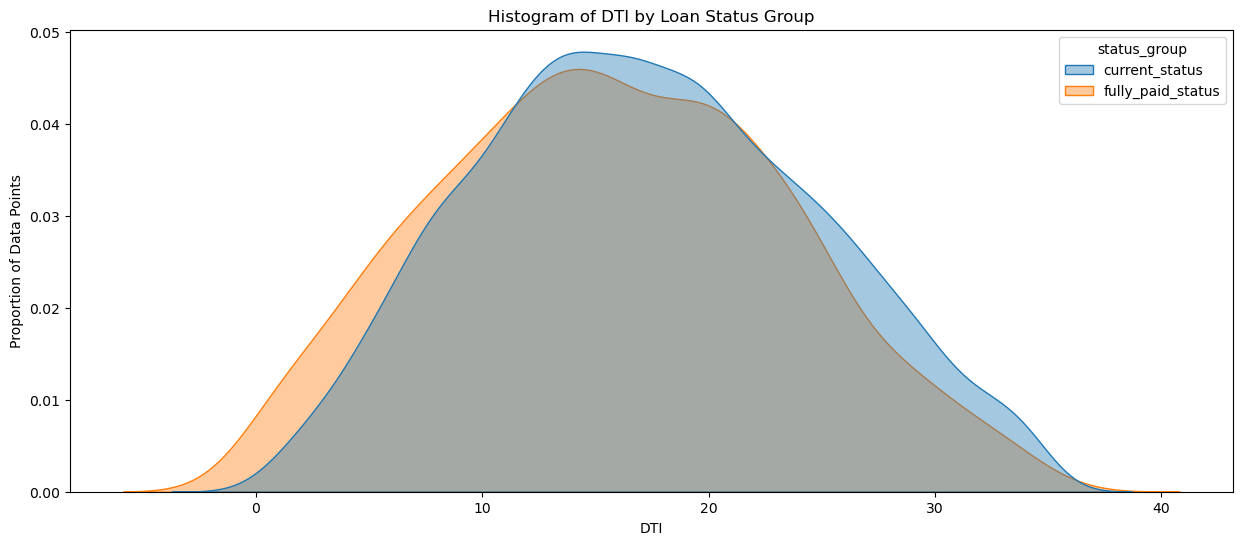

In [1026]:
# agg_df = combined_df.copy()
# agg_df['annual_inc_log'] = np.log(agg_df['annual_inc'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=combined_df, x="dti", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('DTI')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of DTI by Loan Status Group')
plt.show()


DTI of current loans seem to be higher than fully paid loans. From the model, we know that DTI is a top driver for loan going bad.

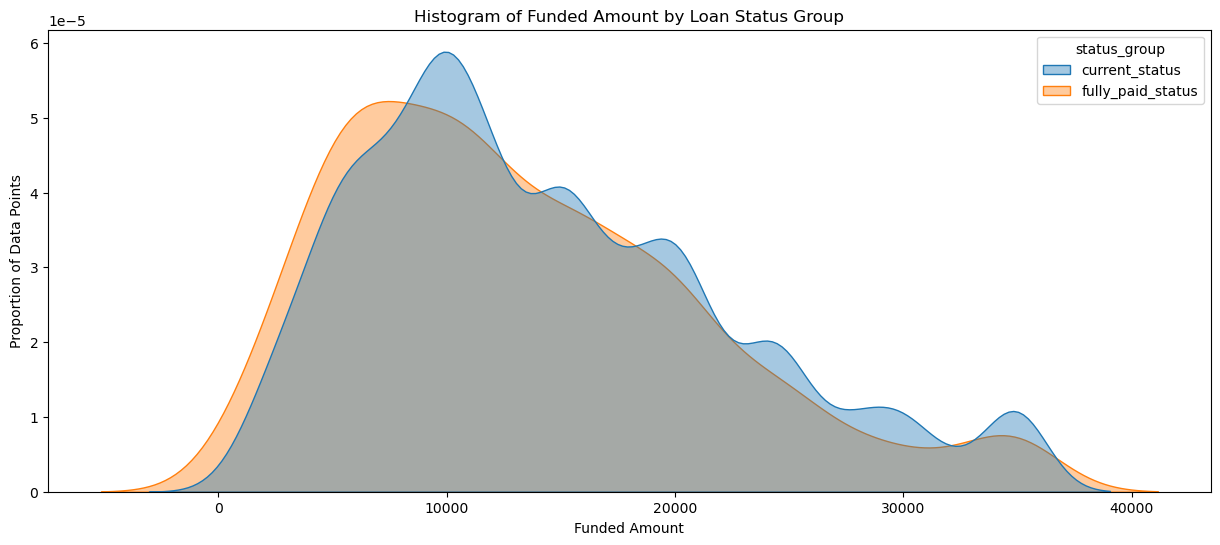

In [1027]:
# agg_df = combined_df.copy()
# agg_df['funded_amnt_log'] = np.log(agg_df['funded_amnt'])

plt.figure(figsize=(15, 6))
sns.kdeplot(data=combined_df, x="funded_amnt", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Funded Amount')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Funded Amount by Loan Status Group')
plt.show()


Funded Amount of current loans seem to be higher than fully paid loans. From the model, we know that Funded Amount is one of the drivers for loan going bad.

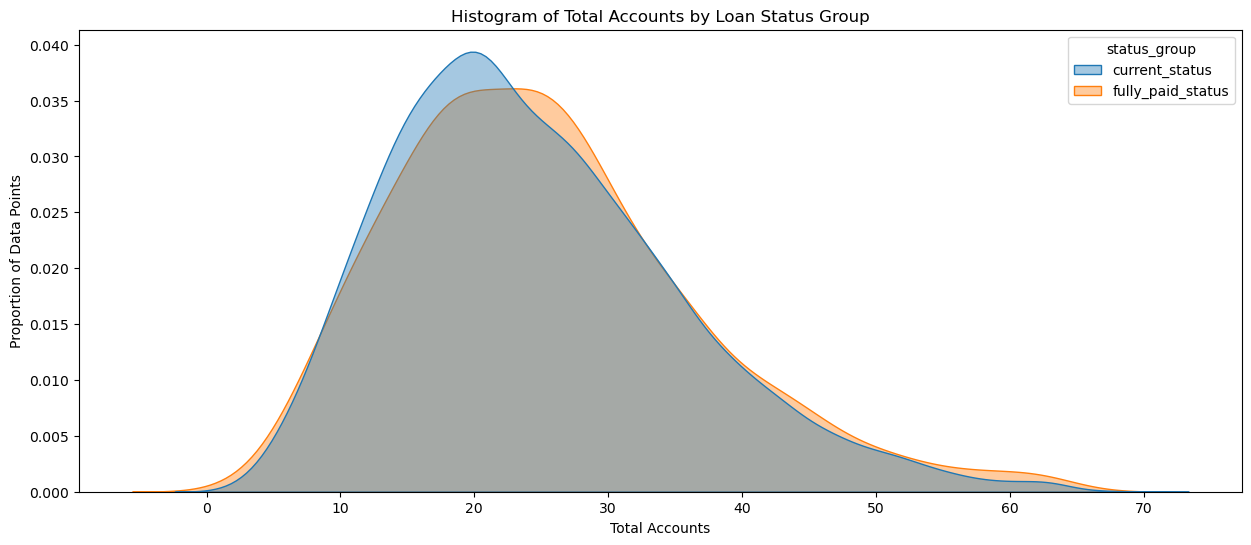

In [1028]:
plt.figure(figsize=(15, 6))
sns.kdeplot(data=combined_df, x="total_acc", hue="status_group", fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Total Accounts')
plt.ylabel('Proportion of Data Points')
plt.title('Histogram of Total Accounts by Loan Status Group')
plt.show()

Total Accounts of current loans seem to be lower than fully paid loans. From the model, we know that lower number of Total Accounts of the borrower is one of the drivers for loan going bad.

In [1031]:
feat_list

['funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'open_acc',
 'revol_bal',
 'total_acc',
 'days_to_cr',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10plus_years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_less_1_year',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']